In [25]:
import numpy as np
import scipy
import os
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,regularizers
from keras.preprocessing .image import ImageDataGenerator
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from matplotlib import pyplot as plt   
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import load_model
from keras import regularizers
import cv2
#FinalModel.add(modelNew)
from keras import regularizers
from keras import layers


Lets load the image from mninst to our test and train dataset. Now lets understand the image size into our test and train data. This shows that we have 60,000 images of 28*28 pixel. Test data shows that we have 10000 images of 28*28 pixel

In [26]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, Y_train),(X_test, Y_test) = mnist.load_data()

### 
print ("Train Data Size:", X_train.shape)
print ("Train Data Label size:",Y_train.shape)

## 
print ("Test Data Size:",X_test.shape)
print ("Test Data Label Size:",Y_test.shape)

Train Data Size: (60000, 28, 28)
Train Data Label size: (60000,)
Test Data Size: (10000, 28, 28)
Test Data Label Size: (10000,)


Lets see some image from test and training data set to inderstand the picture size. Picture size is 28 * 28

Label of First Image in Training Set : 7


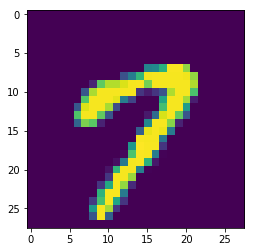

In [27]:
plt.imshow(X_train[15])
print("Label of First Image in Training Set :",Y_train[15])

Lets see image from Training set

Label of First Image in Test Set : 7


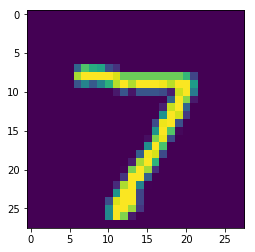

In [28]:
plt.imshow(X_test[0])
print("Label of First Image in Test Set :",Y_test[0])

Preprocess Input data. Convert the 28x28x1 images to 24x24x1 using numpy resize function. This is to help network to learn into lower resolution image. We are then converting into array.

In [29]:
X_train_24 = []
X_test_24 = []


for img in X_train:
  X_train_24.append(np.resize(img,(24,24,1)))
  
for img in X_test:
  X_test_24.append(np.resize(img,(24,24,1)))

#X_test_20 =  X_test.reshape(X_test.shape, 24, 24, 1)

X_train_24 = np.array(X_train_24)
X_test_24 = np.array(X_test_24)
#print("Before Resize:", X_train[0])

print(X_train_24[0].shape)
print(X_test_24[0].shape)


'''
def resize_data(x):
    x_scaled = np.zeros((x.shape[0], 24, 24))
    for i, img in enumerate(x):
        new_image = cv2.resize(img, dsize=(24, 24), interpolation=cv2.INTER_CUBIC)
        x_scaled[i] = new_image

    return x_scaled

# resize train and  test data
x_train_24 = resize_data(X_train)
x_test_24 = resize_data(X_test)
'''

(24, 24, 1)
(24, 24, 1)


'\ndef resize_data(x):\n    x_scaled = np.zeros((x.shape[0], 24, 24))\n    for i, img in enumerate(x):\n        new_image = cv2.resize(img, dsize=(24, 24), interpolation=cv2.INTER_CUBIC)\n        x_scaled[i] = new_image\n\n    return x_scaled\n\n# resize train and  test data\nx_train_24 = resize_data(X_train)\nx_test_24 = resize_data(X_test)\n'

Now we will require to convert them into float 32 and then normalise them.

In [30]:
X_train_24 = X_train_24.astype("float32")
X_test_24 = X_test_24.astype("float32")
X_train_24 = X_train_24/255
X_test_24 = X_test_24/255

The y_train and y_test data are not split into 10 distinct class labels, but rather are represented as a single array with the class values.

In [31]:
print("Training Data labels Before categorical conversion:",Y_train.shape)
print("Test Data labels Before categorical conversion:",Y_test.shape)
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
print("Training Data labels after categorical conversion:",Y_train.shape)
print("Test Data labels after categorical conversion:",Y_test.shape)

Training Data labels Before categorical conversion: (60000,)
Test Data labels Before categorical conversion: (10000,)
Training Data labels after categorical conversion: (60000, 10)
Test Data labels after categorical conversion: (10000, 10)


The input shape parameter should be will be 1 and our input shape as per our earlier resize is (1,24,24)(depth, width, height) of each digit image. Kernel other two parameters correspond to the number of convolution filters to use, the number of rows in each convolution kernel, and the number of columns in each convolution kernel, respectively. *Note: The step size is (1,1) by default. Dropout layer we just added. This is a method for regularizing our model in order to prevent overfitting.

In [32]:
model = Sequential() # here we are defining the model to be executed in sequential
droprate=0.25
#convolution 1st layer
model.add(Conv2D(32,(3,3), activation='relu', strides=(1, 1), padding='valid', input_shape=(24,24,1)))
#model.add(Conv2D(32,(3,1), activation='relu', strides=(1, 1), padding='valid',input_shape=input_24)#(input_24)
model.add(BatchNormalization())
model.add(Dropout(droprate))#3

#convolution 2nd layer
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(droprate))#3

#convolution 3rd layer
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(droprate))#3

#convolution 3rd layer
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(droprate))#3


#Fully connected final layer
model.add(Flatten())
model.add(Dense(200, activation='relu'))

model.add(Dense(10, activation='softmax'))

This is implementation of CLR and taken from https://github.com/bckenstler/CLR

In [33]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

Define the callback

In [34]:
# prepare callbacks
# prepare callbacks
# define path to save model
#git clone https://github.com/jakevdp/sklearn_scipy2013.git

model_path = './mninst_cnn_Base_Iter.hdf5'

clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular2')

#callbacks = [
 #   EarlyStopping(
  #      monitor='val_acc', 
   #     patience=10,
    #    mode='max',
     #   clr,
      #  verbose=1),
    #ModelCheckpoint(model_path,
     #   monitor='val_acc', 
      #  save_best_only=True, 
       # mode='max',
        #verbose=0)
#]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 22, 22, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 22, 22, 32)        128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 20, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 10, 64)        0         
__________

In [36]:
#aa model.fit(x=X_train_20,y=Y_train, batch_size=32,epochs=15,verbose=1, validation_data=(X_test_20, Y_test),callbacks=callbacks)

model.fit(x=X_train_24,y=Y_train, batch_size=32,epochs=15,verbose=1, validation_data=(X_test_24, Y_test),callbacks=[reduce_lr])


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 926s 15ms/step - loss: 0.3052 - acc: 0.9045 - val_loss: 0.1250 - val_acc: 0.9598
Epoch 2/15
60000/60000 [==============================] - 820s 14ms/step - loss: 0.1431 - acc: 0.9561 - val_loss: 0.0829 - val_acc: 0.9742
Epoch 3/15
60000/60000 [==============================] - 812s 14ms/step - loss: 0.1120 - acc: 0.9651 - val_loss: 0.0677 - val_acc: 0.9779
Epoch 4/15
60000/60000 [==============================] - 951s 16ms/step - loss: 0.0940 - acc: 0.9713 - val_loss: 0.0637 - val_acc: 0.9810
Epoch 5/15
60000/60000 [==============================] - 932s 16ms/step - loss: 0.0837 - acc: 0.9742 - val_loss: 0.0537 - val_acc: 0.9831
Epoch 6/15
60000/60000 [==============================] - 955s 16ms/step - loss: 0.0732 - acc: 0.9769 - val_loss: 0.0523 - val_acc: 0.9837
Epoch 7/15
60000/60000 [==============================] - 981s 16ms/step - loss: 0.0689 - acc: 0.9787 - val_loss: 0.

In [37]:
#model.fit(x=X_train_20,y=Y_train, batch_size=32,epochs=15,verbose=1, validation_data=(X_test_20, Y_test),callbacks=callbacks)

No of Layers in Models: 18
10000/10000 [==============================] - 41s 4ms/step
Test loss: 0.05059661450082931
Test accuracy: 0.9865


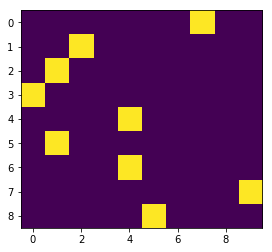

In [38]:
print("No of Layers in Models:",len(model.layers))  # "2")
score = model.evaluate(x= X_test_24, y=Y_test,verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# manual test
Y_pred = model.predict(X_test_24)
#print(Y_pred[:9])
#print(Y_test[:9])
plt.imshow(Y_pred[:9])
plt.imshow(Y_test[:9])

In [39]:
model.save_weights("mninst_cnn_1_IterFinal.hdf5")

In [40]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [41]:
print("No of Layers in Models:",len(model.layers))  

No of Layers in Models: 18


#To set the first 16 layers to non-trainable (weights will not be updated). This is to ensure we only update the weights of
#fcn one

for layer in model.layers[:11]:
      layer.trainable = False

##compile the model again 
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

In Order to run the model on a different resolution image, the number of parameters or the weights on the last layer of model differs. So, we pop the last layers in order to give space for a higher resolution image. Therefore, this makes the architecture slightly different from the architecture for 24x24.

In [46]:
#removing the last two layers so that we can modify the model to accomodate original images

print("No of Layers in Models:",len(model.layers))  



No of Layers in Models: 18


model.layers.pop()
model.layers.pop()
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

print("No of Layers in Models After popping twice:",len(model.layers)) 

**After** popping out we save the model weights. Here, the weights for last layers are also popped out. Therefore, we only store weights except the popped out layers

#save the weights from the model above
model.save_weights("weights_after_pop.hdf5")
print("Saved model to disk") 

In [134]:

modelRevised = Sequential() # here we are defining the model to be executed in sequential
droprate=0.25
#convolution 1st layer
modelRevised.add(Conv2D(32,(3,3), activation='relu', strides=(1, 1), padding='valid', input_shape=(28,28,1)))
#model.add(Conv2D(32,(3,1), activation='relu', strides=(1, 1), padding='valid',input_shape=input_24)#(input_24)
modelRevised.add(BatchNormalization())
modelRevised.add(Dropout(droprate))#3

#convolution 2nd layer
modelRevised.add(Conv2D(64,(3,3), activation='relu'))
modelRevised.add(BatchNormalization())
modelRevised.add(MaxPooling2D())
modelRevised.add(Dropout(droprate))#3

#convolution 3rd layer
modelRevised.add(Conv2D(128,(3,3), activation='relu'))
modelRevised.add(BatchNormalization())
modelRevised.add(MaxPooling2D())
modelRevised.add(Dropout(droprate))#3

#convolution 3rd layer
modelRevised.add(Conv2D(128,(3,3), activation='relu'))
modelRevised.add(BatchNormalization())
modelRevised.add(MaxPooling2D())
modelRevised.add(Dropout(droprate))#3


#Fully connected final layer
modelRevised.add(Flatten())
modelRevised.add(Dense(200, activation='relu'))

modelRevised.add(Dense(10, activation='softmax'))

In [135]:
modelRevised.load_weights('mninst_cnn_1_IterFinal.hdf5')


In [136]:
modelRevised.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_62 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_71 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_63 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 12, 12, 64)        0         
__________

modelRevised.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
             metrics=['accuracy'])
modelRevised.summary()

Following workaround approach has been taken as per https://github.com/keras-team/keras/issues/2371 since model.pop is not removing last layer.

new_model.summary()

In [137]:
#inp = modelRevised.input
#out = modelRevised.layers[-3].output
#model2 = Sequential()
#modelNew = Model(inp, out)  # create a new model which doesn't have the last two layers in VGG16
#modelNew = Model(inp,out)  # create a new model which doesn't have the last two layers and also skipped the first layer as we have different input

#modelNew.summary()

In [138]:
modelRevised.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_62 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_71 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_63 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 12, 12, 64)        0         
__________

In [139]:
modelRevised.pop()  ## removeing last two dense layer 
modelRevised.pop()
modelRevised.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_62 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_71 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_63 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 12, 12, 64)        0         
__________

In [140]:
# Add fully connected layer with a ReLU activation function and L2 regularization
modelRevised.add(layers.Dense(units=240, 
                            kernel_regularizer=regularizers.l2(0.05),
                            activation='relu'))

modelRevised.add(BatchNormalization())
modelRevised.add(Dropout(0.5))#3

#Fully connected last  layer
#fully connected last layer
#FinalModel.add(Dense(100, activation='relu'),kernel_regularizer=regularizers.l2(0.05),activity_regularizer=regularizers.l1(0.05))
modelRevised.add(layers.Dense(units=100, 
                            activation='relu'))
modelRevised.add(Dropout(0.5))#3

#FinalModel.add(Dense(60, activation='relu'))


modelRevised.add(Dense(10, activation='softmax'))

In [141]:
#To set the first 16 layers to non-trainable (weights will not be updated). This is to ensure we only update the weights of
#fcn one

for layer in modelRevised.layers[2:10]:
      layer.trainable = False

In [142]:
modelRevised.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
             metrics=['accuracy'])
modelRevised.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_62 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_71 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_63 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 12, 12, 64)        0         
__________

In [143]:
X_train_Final=[]
X_test_Final=[]

for img in X_train:
  X_train_Final.append(np.resize(img,(28,28,1)))

for img in X_test:
  X_test_Final.append(np.resize(img,(28,28,1)))

X_train_Final = np.array(X_train_Final)
X_test_Final = np.array(X_test_Final)
X_train_Final = X_train_Final.astype("float32")
X_test_Final = X_test_Final.astype("float32")
X_train_Final = X_train_Final/255
X_test_Final = X_test_Final/255


In [144]:
mylayer =modelRevised.layers
print(mylayer)

[<keras.layers.convolutional.Conv2D object at 0x0000022A988C71D0>, <keras.layers.normalization.BatchNormalization object at 0x0000022A98927390>, <keras.layers.core.Dropout object at 0x0000022A988CF2E8>, <keras.layers.convolutional.Conv2D object at 0x0000022A988CFCF8>, <keras.layers.normalization.BatchNormalization object at 0x0000022A988C7198>, <keras.layers.pooling.MaxPooling2D object at 0x0000022A98892CC0>, <keras.layers.core.Dropout object at 0x0000022A9AD42588>, <keras.layers.convolutional.Conv2D object at 0x0000022A9AD694E0>, <keras.layers.normalization.BatchNormalization object at 0x0000022A98892B38>, <keras.layers.pooling.MaxPooling2D object at 0x0000022A9AE2D9E8>, <keras.layers.core.Dropout object at 0x0000022A9AE5CD30>, <keras.layers.convolutional.Conv2D object at 0x0000022A9AEA2240>, <keras.layers.normalization.BatchNormalization object at 0x0000022A9AE2D978>, <keras.layers.pooling.MaxPooling2D object at 0x0000022A9AF4BFD0>, <keras.layers.core.Dropout object at 0x0000022A9AF8

In [145]:
#Load the weights from above and then run the model on train data of actual size, for remaining nmber of epochs
FinalModelRun = modelRevised.fit(x=X_train_Final, y=Y_train,
                                batch_size=32,
                                epochs=25,
                                verbose=1,
                                callbacks=[reduce_lr],
                                validation_data=(X_test_Final, Y_test)
                               )  


Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 1069s 18ms/step - loss: 1.5597 - acc: 0.8377 - val_loss: 0.4528 - val_acc: 0.9384
Epoch 2/25
60000/60000 [==============================] - 1148s 19ms/step - loss: 0.4545 - acc: 0.9313 - val_loss: 0.4349 - val_acc: 0.9321
Epoch 3/25
60000/60000 [==============================] - 1023s 17ms/step - loss: 0.3823 - acc: 0.9446 - val_loss: 0.4199 - val_acc: 0.9342
Epoch 4/25
60000/60000 [==============================] - 1150s 19ms/step - loss: 0.3551 - acc: 0.9515 - val_loss: 0.3892 - val_acc: 0.9400
Epoch 5/25
60000/60000 [==============================] - 1163s 19ms/step - loss: 0.3332 - acc: 0.9548 - val_loss: 0.3624 - val_acc: 0.9516
Epoch 6/25
60000/60000 [==============================] - 1161s 19ms/step - loss: 0.3196 - acc: 0.9591 - val_loss: 0.3560 - val_acc: 0.9494
Epoch 7/25
60000/60000 [==============================] - 1033s 17ms/step - loss: 0.3072 - acc: 0.9596 - val_l

Following one evaluates accuracy on validation and test data epoch wise

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


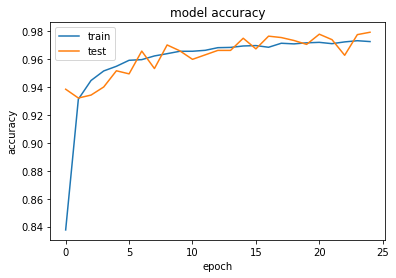

In [146]:
print(FinalModelRun.history.keys())
plt.plot(FinalModelRun.history['acc'])
plt.plot(FinalModelRun.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Now we will summarise the loss during epochs with training and test data. Here we will see as loss is coming down as we go with more epochs. If these parallel plots start to depart consistently, it might be a sign to stop training at an earlier epoch.

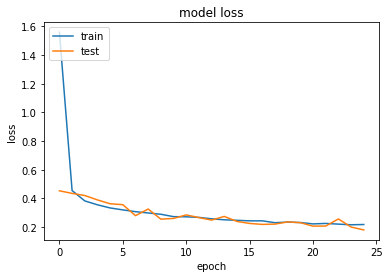

In [148]:
plt.plot(FinalModelRun.history['loss'])
plt.plot(FinalModelRun.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [150]:
#]
reduce_lr_revised = ReduceLROnPlateau(monitor='val_loss', factor=0.25,verbose=1,
                              patience=5, min_lr=0.001)

In [154]:
modelWOImageChange = Sequential() # here we are defining the model to be executed in sequential
droprate=0.15
droprateRev=0.3
#convolution 1st layer
modelWOImageChange.add(Conv2D(32,(3,3), activation='relu', strides=(1, 1), padding='valid', input_shape=(28,28,1)))
#model.add(Conv2D(32,(3,1), activation='relu', strides=(1, 1), padding='valid',input_shape=input_24)#(input_24)
modelWOImageChange.add(BatchNormalization())
modelWOImageChange.add(Dropout(droprate))#3

#convolution 2nd layer
modelWOImageChange.add(Conv2D(64,(3,3), activation='relu'))
modelWOImageChange.add(BatchNormalization())
modelWOImageChange.add(MaxPooling2D())
modelWOImageChange.add(Dropout(droprate))#3

#convolution 3rd layer
modelWOImageChange.add(Conv2D(128,(3,3), activation='relu'))
modelWOImageChange.add(BatchNormalization())
modelWOImageChange.add(MaxPooling2D())
modelWOImageChange.add(Dropout(droprateRev))#3

#convolution 3rd layer
modelWOImageChange.add(Conv2D(256,(1,1), activation='relu'))
modelWOImageChange.add(BatchNormalization())
modelWOImageChange.add(MaxPooling2D())
modelWOImageChange.add(Dropout(droprateRev))#3


#Fully connected final layer
modelWOImageChange.add(Flatten())
modelWOImageChange.add(Dense(210, activation='relu',use_bias=False, kernel_initializer='glorot_uniform'))
modelWOImageChange.add(Dropout(droprateRev))#3


modelWOImageChange.add(Dense(10, activation='softmax'))

modelWOImageChange.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
             metrics=['accuracy'])
modelWOImageChange.summary()

callbacks = [
    EarlyStopping(
        monitor='val_acc', 
        patience=10,
        mode='max',
        verbose=1),
    ModelCheckpoint(model_path,
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]

FinalModelRunWOImage = modelWOImageChange.fit(x=X_train_Final, y=Y_train,
                                batch_size=32,
                                epochs=15,
                                verbose=1,
                                callbacks=[reduce_lr_revised],
                                validation_data=(X_test_Final, Y_test)
                               )  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_83 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_96 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_84 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 12, 12, 64)        0         
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


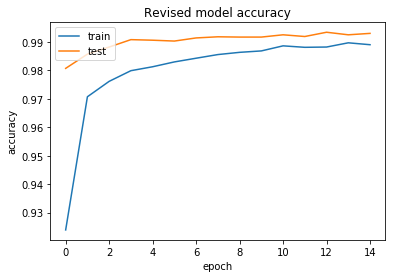

In [155]:
print(FinalModelRunWOImage.history.keys())
plt.plot(FinalModelRunWOImage.history['acc'])
plt.plot(FinalModelRunWOImage.history['val_acc'])
plt.title('Revised model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


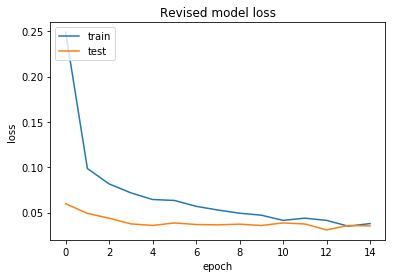

In [156]:
plt.plot(FinalModelRunWOImage.history['loss'])
plt.plot(FinalModelRunWOImage.history['val_loss'])
plt.title('Revised model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()